# Credit Card Fraud Detection

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import imblearn
import torch
import warnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import RocCurveDisplay, ConfusionMatrixDisplay, classification_report, roc_auc_score, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score, learning_curve

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

dataset findable at https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data

In [2]:
df = pd.read_csv("./creditcard.csv")

### Data Pretreatment

Scaling delle due variabili non già scalate

In [3]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

In [ ]:
def remove_outliers_iqr(df, col, threshold=20):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - threshold * IQR
    upper_bound = Q3 + threshold * IQR

    mask_class0 = df['Class'] == 0
    mask_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
    mask_remove = mask_class0 & mask_outlier

    outliers = df[mask_remove]
    df_cleaned = df.drop(df[mask_remove].index)
    return df_cleaned, outliers

count_outl = 0

# df, outliers = remove_outliers_iqr(df, "V10", threshold=20)
# count_outl += len(outliers)
print(f"Total outliers removed: {count_outl}")

In [ ]:
def set_distribution(y):
    counts = y.value_counts()
    percentages = y.value_counts(normalize=True) * 100
    print(pd.DataFrame({'Count': counts, 'Percentage': percentages.round(3)}))

set_distribution(df['Class'])

        Count  Percentage
Class                    
0      284315      99.827
1         492       0.173


Train Test Split

In [5]:
X = df[df.columns[:-1]]
y = df[df.columns[-1]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

print("TRAIN")
set_distribution(y_train)
print("\nTEST")
set_distribution(y_test)

TRAIN
        Count  Percentage
Class                    
0      227451      99.827
1         394       0.173

TEST
       Count  Percentage
Class                   
0      56864      99.828
1         98       0.172


# Metriche

In [6]:
def plot_roc_curve(labels, y_pred1, y_pred2, y_pred3):
    fig, ax = plt.subplots(figsize=(8, 6))
    RocCurveDisplay.from_predictions(labels, y_pred1, ax=ax)
    RocCurveDisplay.from_predictions(labels, y_pred2, ax=ax)
    RocCurveDisplay.from_predictions(labels, y_pred3, ax=ax)
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_title("ROC Curve")
    ax.legend([
        "Logistic Regression {:.4f}".format(roc_auc_score(labels, y_pred1)), 
        "Decision Tree {:.4f}".format(roc_auc_score(labels, y_pred2)), 
        "SVC {:.4f}".format(roc_auc_score(labels, y_pred3)), 
        "Random Guess 0.5"
    ])
    plt.tight_layout()
    plt.show()

# 1. Classification Random Under Sample

In [7]:
X_train_rus, y_train_rus = RandomUnderSampler(random_state=0).fit_resample(X_train, y_train)
X_test_balan, y_test_balan = RandomUnderSampler(random_state=0).fit_resample(X_test, y_test) # balanced test set per comparare ai test bilanciati

Most positive: ['V4', 'V11', 'V2', 'V19']
Most negative: ['V14', 'V12', 'V10', 'V16']


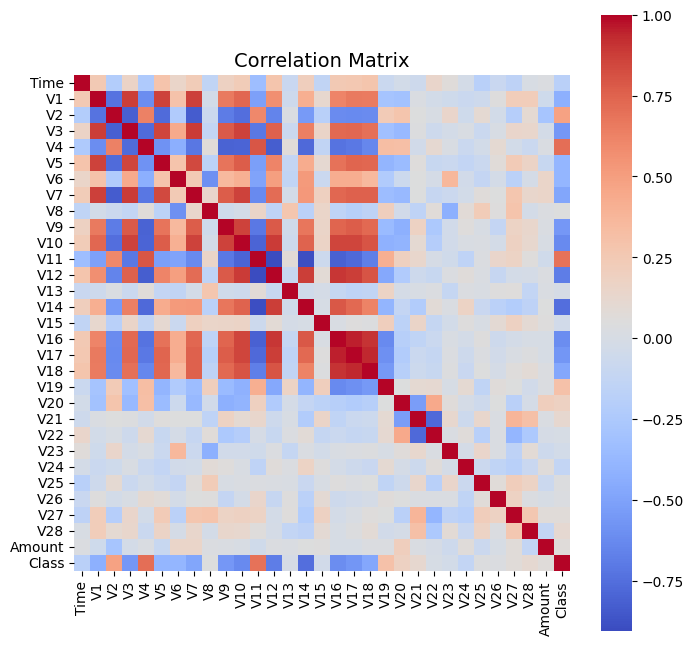

In [8]:
corr_matrix = pd.concat([X_train_rus, y_train_rus], axis=1).corr()

corr_with_class = corr_matrix.iloc[-1, :-1]
most_pos = corr_with_class.sort_values(ascending=False).head(4).index.tolist()
most_neg = corr_with_class.sort_values().head(4).index.tolist()
print("Most positive:", most_pos)
print("Most negative:", most_neg)

plt.figure(figsize=(8,8))
sns.heatmap(corr_matrix, cmap="coolwarm", square=True)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

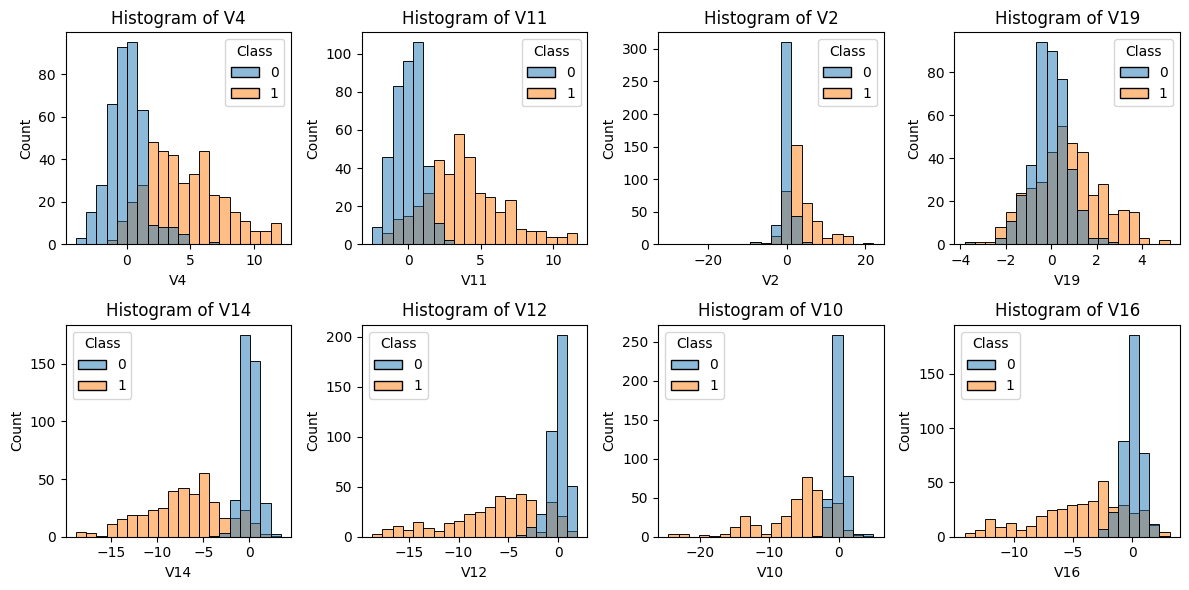

In [ ]:
def plot_dist(X, y, cols, bins=20):
    n = len(cols)
    nrows, ncols = 2, 4
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 6))
    axes = axes.flatten()
    
    for i, col in enumerate(cols):
        sns.histplot(data=X, x=col, hue=y, bins=bins, ax=axes[i])
        axes[i].set_title(f"Histogram of {col}")
    
    plt.tight_layout()
    plt.show()

plot_dist(X_train_rus, y_train_rus, most_pos + most_neg)

In [ ]:
classifiers = {
    "Logistic Regression": LogisticRegression( random_state=0),
    "Decision Tree": DecisionTreeClassifier(random_state=0),
    "Support Vector Classifier": SVC(random_state=0)
}

params = {
    "Logistic Regression": {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'solver': ['liblinear']},
    "Decision Tree": {'criterion': ["gini", "entropy"], "max_depth": list(range(2,4,1)), 'min_samples_leaf': list(range(5,7,1))},
    "Support Vector Classifier": {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']},
}

samplers = {
    "RandomUnderSampler": RandomUnderSampler(),
    "NearMiss": NearMiss(),
    "SMOTE": SMOTE()
}

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

def gridsearch(classifier, params, sampler):
    pipeline = make_pipeline(sampler, classifier)
    pipeline_params = {}
    for key, value in params.items():
        pipeline_params[f'{classifier.__class__.__name__.lower()}__' + key] = value
    grid_classifier = GridSearchCV(pipeline, pipeline_params, cv=stratified_kfold, n_jobs=-1, scoring='f1')
    grid_classifier.fit(X_train, y_train)
    best_classifier = grid_classifier.best_estimator_
    best_params = grid_classifier.best_params_
    return best_classifier, best_params

print("Cross-Validation Scores applying GridSearch:\n")
for key, classifier in classifiers.items():
    best_clf, best_params = gridsearch(classifier, params[key], NearMiss())
    cv_score = cross_val_score(best_clf, X_train, y_train, cv=stratified_kfold)
    print(f"{key} score: {round(cv_score.mean()*100.0, 2)}")
    print(best_params, "\n")

Cross-Validation Scores applying GridSearch:

Logistic Regression score: 64.69
{'logisticregression__C': 0.1, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'} 

Decision Tree score: 69.92
{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': 2, 'decisiontreeclassifier__min_samples_leaf': 6} 

Support Vector Classifier score: 99.76
{'svc__C': 0.5, 'svc__kernel': 'poly'} 



In [ ]:
def plot_2_conf_matrix(pred, pred_balan, label):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    cm1 = confusion_matrix(y_test, pred)
    disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=[0, 1])
    disp1.plot(ax=ax[0], cmap=plt.cm.Blues, colorbar=False)
    ax[0].set_title(f"{label[0]} on {label[1]} train, unbalanced test")

    cm2 = confusion_matrix(y_test_balan, pred_balan)
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=[0, 1])
    disp2.plot(ax=ax[1], cmap=plt.cm.Blues, colorbar=False)
    ax[1].set_title(f"{label[0]} on {label[1]} train, balanced test")

    plt.tight_layout()
    plt.show()

### Logistic Regression RUS

              precision    recall  f1-score   support

           0      1.000     0.965     0.982     56864
           1      0.041     0.888     0.079        98

    accuracy                          0.964     56962
   macro avg      0.521     0.926     0.530     56962
weighted avg      0.998     0.964     0.980     56962
 

              precision    recall  f1-score   support

           0      0.896     0.969     0.931        98
           1      0.967     0.888     0.926        98

    accuracy                          0.929       196
   macro avg      0.931     0.929     0.928       196
weighted avg      0.931     0.929     0.928       196
 



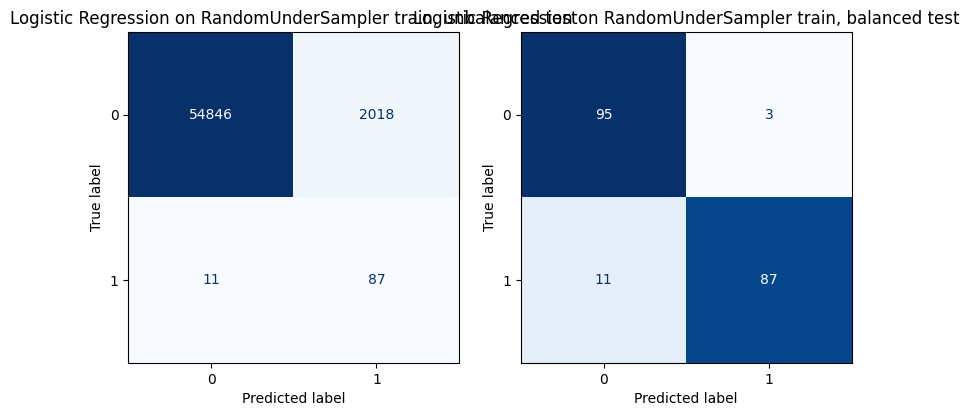

In [ ]:
lr_rus = LogisticRegression(max_iter=1000, random_state=0, C=0.01, penalty='l2', solver='liblinear')
lr_rus.fit(X_train_rus, y_train_rus)
lr_rus_pred = lr_rus.predict(X_test)
lr_rus_pred_balan = lr_rus.predict(X_test_balan)
print(classification_report(y_test, lr_rus_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, lr_rus_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(lr_rus_pred, lr_rus_pred_balan, ['Logistic Regression', 'RandomUnderSampler'])

### Decision Tree RUS

              precision    recall  f1-score   support

           0      1.000     0.975     0.987     56864
           1      0.054     0.827     0.101        98

    accuracy                          0.975     56962
   macro avg      0.527     0.901     0.544     56962
weighted avg      0.998     0.975     0.986     56962
 

              precision    recall  f1-score   support

           0      0.851     0.990     0.915        98
           1      0.988     0.827     0.900        98

    accuracy                          0.908       196
   macro avg      0.919     0.908     0.908       196
weighted avg      0.919     0.908     0.908       196
 



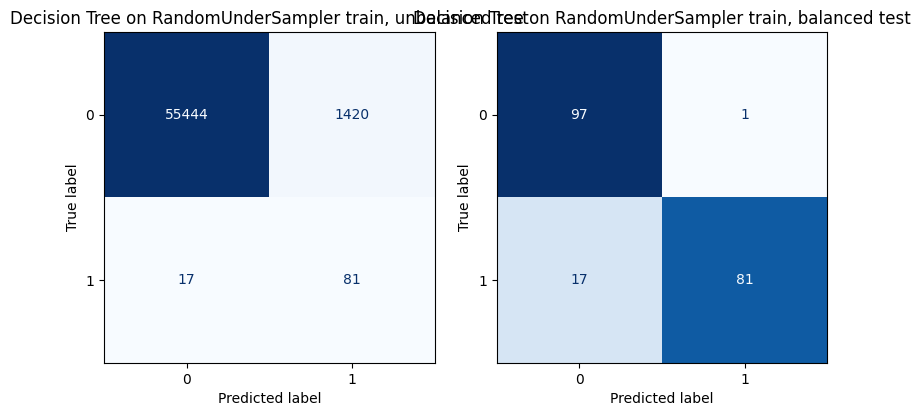

In [ ]:
dt_rus = DecisionTreeClassifier(criterion='entropy', max_depth=2, min_samples_leaf=5, random_state=0)
dt_rus.fit(X_train_rus, y_train_rus)
dt_rus_pred = dt_rus.predict(X_test)
dt_rus_pred_balan = dt_rus.predict(X_test_balan)
print(classification_report(y_test, dt_rus_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, dt_rus_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(dt_rus_pred, dt_rus_pred_balan, ["Decision Tree", "RandomUnderSampler"])

### SVM Classifier RUS

              precision    recall  f1-score   support

           0      1.000     0.965     0.982     56864
           1      0.041     0.888     0.079        98

    accuracy                          0.964     56962
   macro avg      0.521     0.926     0.530     56962
weighted avg      0.998     0.964     0.980     56962
 

              precision    recall  f1-score   support

           0      0.896     0.969     0.931        98
           1      0.967     0.888     0.926        98

    accuracy                          0.929       196
   macro avg      0.931     0.929     0.928       196
weighted avg      0.931     0.929     0.928       196
 



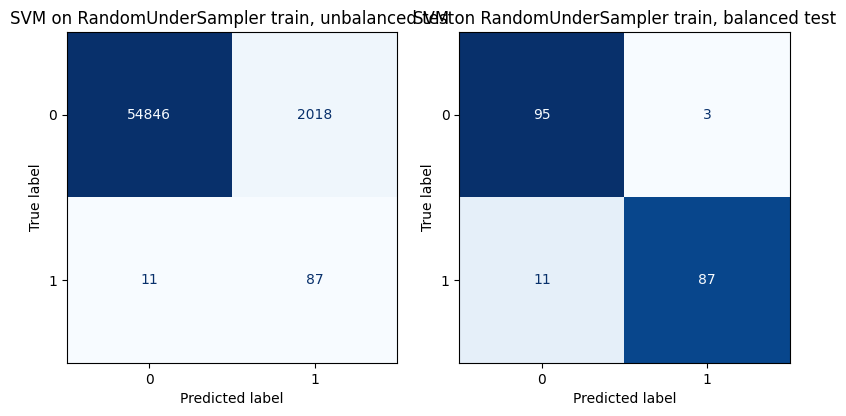

In [ ]:
svc_rus = SVC(C=0.5, kernel='poly', random_state=0)
svc_rus.fit(X_train_rus, y_train_rus)
svc_rus_pred = lr_rus.predict(X_test)
svc_rus_pred_balan = lr_rus.predict(X_test_balan)
print(classification_report(y_test, svc_rus_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, svc_rus_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(svc_rus_pred, svc_rus_pred_balan, ["SVM", "RandomUnderSampler"])

# 2. Classification NearMiss

In [16]:
X_train_nm, y_train_nm = NearMiss().fit_resample(X_train, y_train)

### Logistic Regression NearMiss

              precision    recall  f1-score   support

           0      1.000     0.664     0.798     56864
           1      0.004     0.867     0.009        98

    accuracy                          0.664     56962
   macro avg      0.502     0.766     0.403     56962
weighted avg      0.998     0.664     0.797     56962
 

              precision    recall  f1-score   support

           0      0.822     0.612     0.702        98
           1      0.691     0.867     0.769        98

    accuracy                          0.740       196
   macro avg      0.756     0.740     0.735       196
weighted avg      0.756     0.740     0.735       196
 



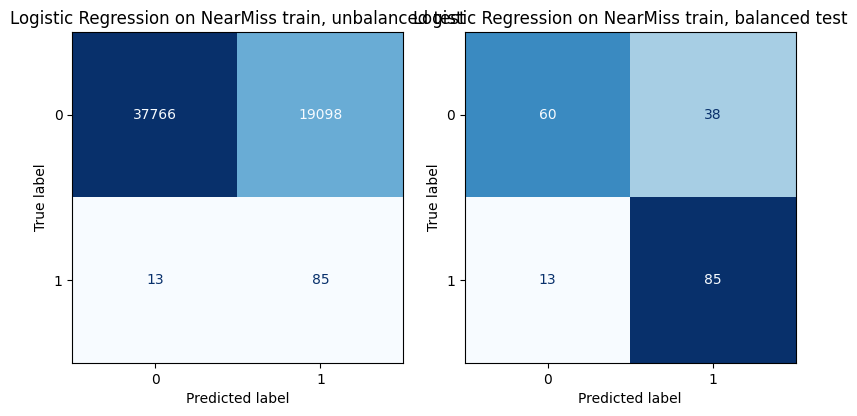

In [ ]:
lr_nm = LogisticRegression(max_iter=1000, random_state=0, C=0.01, penalty='l2', solver='liblinear')
lr_nm.fit(X_train_nm, y_train_nm)
lr_nm_pred = lr_nm.predict(X_test)
lr_nm_pred_balan = lr_nm.predict(X_test_balan)
print(classification_report(y_test, lr_nm_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, lr_nm_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(lr_nm_pred, lr_nm_pred_balan, ["Logistic Regression", "NearMiss"])

### Decision Tree NearMiss

              precision    recall  f1-score   support

           0      1.000     0.860     0.925     56864
           1      0.011     0.888     0.021        98

    accuracy                          0.861     56962
   macro avg      0.505     0.874     0.473     56962
weighted avg      0.998     0.861     0.923     56962
 

              precision    recall  f1-score   support

           0      0.884     0.857     0.870        98
           1      0.861     0.888     0.874        98

    accuracy                          0.872       196
   macro avg      0.873     0.872     0.872       196
weighted avg      0.873     0.872     0.872       196
 



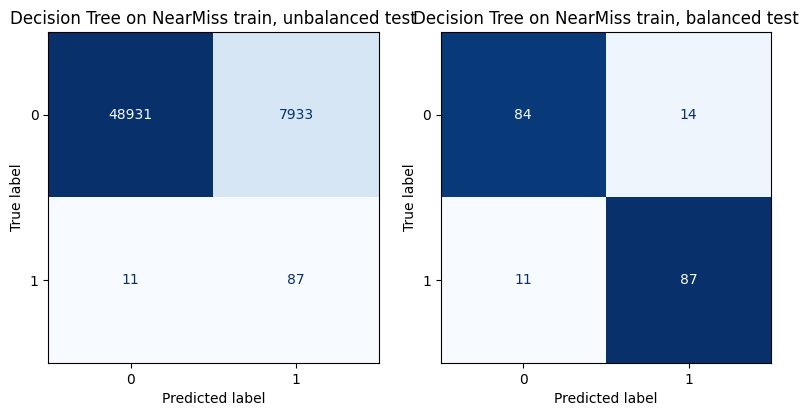

In [ ]:
dt_nm = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=6, random_state=0)
dt_nm.fit(X_train_nm, y_train_nm)
dt_nm_pred = dt_nm.predict(X_test)
dt_nm_pred_balan = dt_nm.predict(X_test_balan)
print(classification_report(y_test, dt_nm_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, dt_nm_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(dt_nm_pred, dt_nm_pred_balan, ["Decision Tree", "NearMiss"])

### SVM Classifier NearMiss

              precision    recall  f1-score   support

           0      0.999     0.998     0.999     56864
           1      0.309     0.592     0.406        98

    accuracy                          0.997     56962
   macro avg      0.654     0.795     0.702     56962
weighted avg      0.998     0.997     0.997     56962
 

              precision    recall  f1-score   support

           0      0.710     1.000     0.831        98
           1      1.000     0.592     0.744        98

    accuracy                          0.796       196
   macro avg      0.855     0.796     0.787       196
weighted avg      0.855     0.796     0.787       196
 



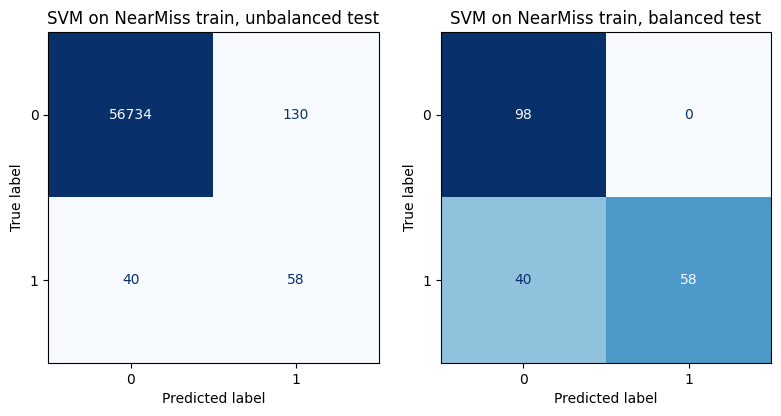

In [ ]:
svc_nm = SVC(C=0.5, kernel='poly', random_state=0)
svc_nm.fit(X_train_nm, y_train_nm)
svc_nm_pred = svc_nm.predict(X_test)
svc_nm_pred_balan = svc_nm.predict(X_test_balan)
print(classification_report(y_test, svc_nm_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, svc_nm_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(svc_nm_pred, svc_nm_pred_balan, ["SVM", "NearMiss"])

# 3. Classification SMOTE

In [20]:
X_train_smote, y_train_smote = SMOTE(random_state=0).fit_resample(X_train, y_train)

### Logistic Regression SMOTE

              precision    recall  f1-score   support

           0      1.000     0.977     0.988     56864
           1      0.064     0.888     0.119        98

    accuracy                          0.977     56962
   macro avg      0.532     0.933     0.554     56962
weighted avg      0.998     0.977     0.987     56962
 

              precision    recall  f1-score   support

           0      0.896     0.969     0.931        98
           1      0.967     0.888     0.926        98

    accuracy                          0.929       196
   macro avg      0.931     0.929     0.928       196
weighted avg      0.931     0.929     0.928       196
 



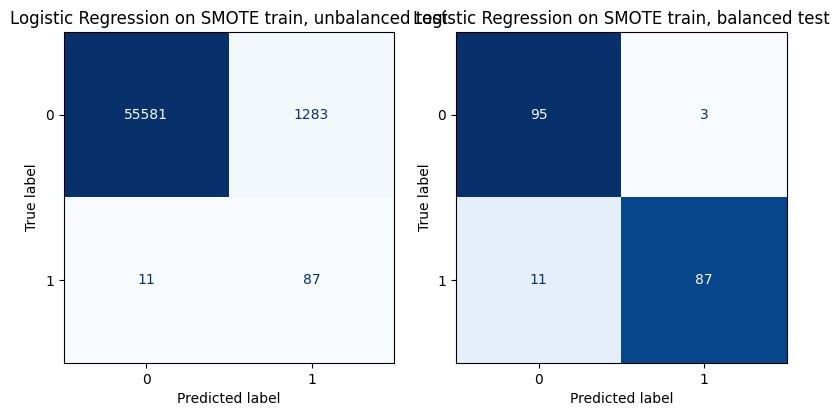

In [ ]:
lr_smote = LogisticRegression(max_iter=1000, random_state=0, C=0.001, penalty='l2', solver='liblinear')
lr_smote.fit(X_train_smote, y_train_smote)
lr_smote_pred = lr_smote.predict(X_test)
lr_smote_pred_balan = lr_smote.predict(X_test_balan)
print(classification_report(y_test, lr_smote_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, lr_smote_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(lr_smote_pred, lr_smote_pred_balan, ["Logistic Regression", "SMOTE"])

### Decision Tree SMOTE

              precision    recall  f1-score   support

           0      1.000     0.974     0.987     56864
           1      0.052     0.827     0.098        98

    accuracy                          0.974     56962
   macro avg      0.526     0.900     0.543     56962
weighted avg      0.998     0.974     0.985     56962
 

              precision    recall  f1-score   support

           0      0.851     0.990     0.915        98
           1      0.988     0.827     0.900        98

    accuracy                          0.908       196
   macro avg      0.919     0.908     0.908       196
weighted avg      0.919     0.908     0.908       196
 



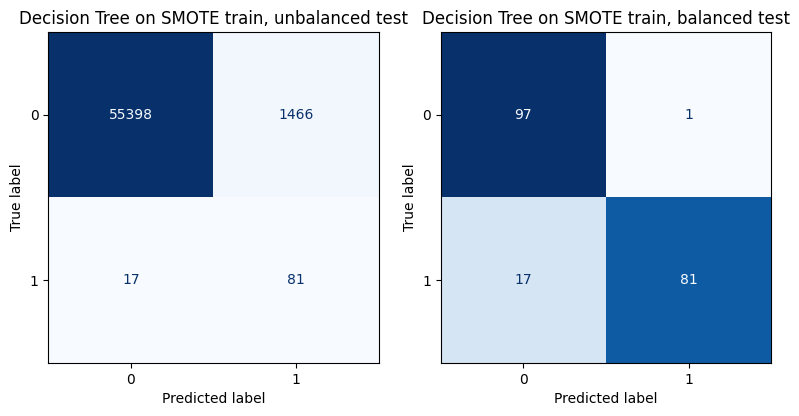

In [ ]:
dt_smote = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=5, random_state=0)
dt_smote.fit(X_train_smote, y_train_smote)
dt_smote_pred = dt_smote.predict(X_test)
dt_smote_pred_balan = dt_smote.predict(X_test_balan)
print(classification_report(y_test, dt_smote_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, dt_smote_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(dt_smote_pred, dt_smote_pred_balan, ["Decision Tree", "SMOTE"])

### SVM Classifier SMOTE

              precision    recall  f1-score   support

           0      1.000     0.974     0.987     56864
           1      0.056     0.888     0.106        98

    accuracy                          0.974     56962
   macro avg      0.528     0.931     0.546     56962
weighted avg      0.998     0.974     0.985     56962
 

              precision    recall  f1-score   support

           0      0.895     0.959     0.926        98
           1      0.956     0.888     0.921        98

    accuracy                          0.923       196
   macro avg      0.926     0.923     0.923       196
weighted avg      0.926     0.923     0.923       196
 



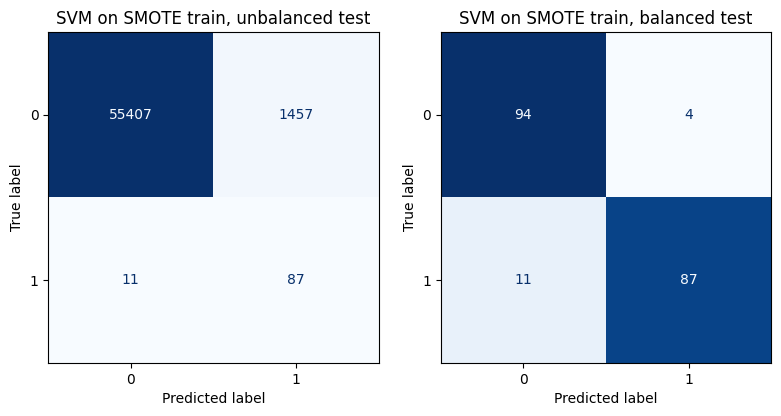

In [ ]:
svc_smote = SVC(C=0.5, kernel='linear', random_state=0)
svc_smote.fit(X_train_smote, y_train_smote)
svc_smote_pred = svc_smote.predict(X_test)
svc_smote_pred_balan = svc_smote.predict(X_test_balan)
print(classification_report(y_test, svc_smote_pred, zero_division=0, digits=3), "\n")
print(classification_report(y_test_balan, svc_smote_pred_balan, zero_division=0, digits=3), "\n")
plot_2_conf_matrix(svc_smote_pred, svc_smote_pred_balan, ["SVM", "SMOTE"])

# 4. Testing & Comparisons

In [24]:
def plot_learning_curve(model1, model2, model3, X, y):
    
    train_sizes = np.linspace(0.1, 1.0, 5)
    fig, ax = plt.subplots(1, 3, figsize=(10, 4))

    train_sizes1, train_scores1, test_scores1 = learning_curve(model1, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes)
    train_mean1 = np.mean(train_scores1, axis=1)
    test_mean1 = np.mean(test_scores1, axis=1)
    ax[0].plot(train_sizes1, train_mean1, 'o-', color='blue', label='Training score')
    ax[0].plot(train_sizes1, test_mean1, 'o-', color='red', label='Cross-validation score')
    ax[0].set_title("Logistic Regression")
    ax[0].set_xlabel("Training Size")
    ax[0].set_ylabel("Score")
    ax[0].legend(loc='best')

    train_sizes2, train_scores2, test_scores2 = learning_curve(model2, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes)
    train_mean2 = np.mean(train_scores2, axis=1)
    test_mean2 = np.mean(test_scores2, axis=1)
    ax[1].plot(train_sizes2, train_mean2, 'o-', color='blue', label='Training score')
    ax[1].plot(train_sizes2, test_mean2, 'o-', color='red', label='Cross-validation score')
    ax[1].set_title("Decision Tree")
    ax[1].set_xlabel("Training Size")
    ax[1].set_ylabel("Score")
    ax[1].legend(loc='best')

    train_sizes3, train_scores3, test_scores3 = learning_curve(model3, X, y, cv=5, n_jobs=-1, train_sizes=train_sizes)
    train_mean3 = np.mean(train_scores3, axis=1)
    test_mean3 = np.mean(test_scores3, axis=1)
    ax[2].plot(train_sizes3, train_mean3, 'o-', color='blue', label='Training score')
    ax[2].plot(train_sizes3, test_mean3, 'o-', color='red', label='Cross-validation score')
    ax[2].set_title("SVC")
    ax[2].set_xlabel("Training Size")
    ax[2].set_ylabel("Score")
    ax[2].legend(loc='best')

    plt.tight_layout()
    plt.show()

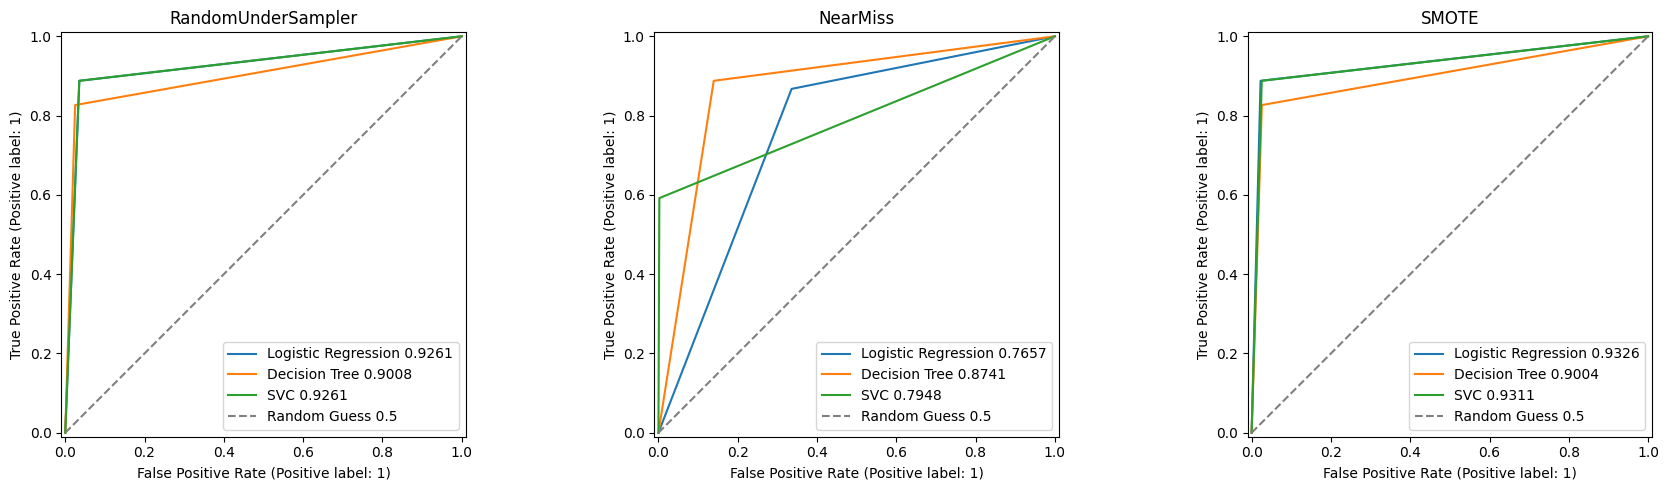

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

RocCurveDisplay.from_predictions(y_test, lr_rus_pred, ax=axes[0])
RocCurveDisplay.from_predictions(y_test, dt_rus_pred, ax=axes[0])
RocCurveDisplay.from_predictions(y_test, svc_rus_pred, ax=axes[0])
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set_title("RandomUnderSampler")
axes[0].legend([
    "Logistic Regression {:.4f}".format(roc_auc_score(y_test, lr_rus_pred)),
    "Decision Tree {:.4f}".format(roc_auc_score(y_test, dt_rus_pred)),
    "SVC {:.4f}".format(roc_auc_score(y_test, svc_rus_pred)),
    "Random Guess 0.5"
])

RocCurveDisplay.from_predictions(y_test, lr_nm_pred, ax=axes[1])
RocCurveDisplay.from_predictions(y_test, dt_nm_pred, ax=axes[1])
RocCurveDisplay.from_predictions(y_test, svc_nm_pred, ax=axes[1])
axes[1].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[1].set_title("NearMiss")
axes[1].legend([
    "Logistic Regression {:.4f}".format(roc_auc_score(y_test, lr_nm_pred)),
    "Decision Tree {:.4f}".format(roc_auc_score(y_test, dt_nm_pred)),
    "SVC {:.4f}".format(roc_auc_score(y_test, svc_nm_pred)),
    "Random Guess 0.5"
])

RocCurveDisplay.from_predictions(y_test, lr_smote_pred, ax=axes[2])
RocCurveDisplay.from_predictions(y_test, dt_smote_pred, ax=axes[2])
RocCurveDisplay.from_predictions(y_test, svc_smote_pred, ax=axes[2])
axes[2].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[2].set_title("SMOTE")
axes[2].legend([
    "Logistic Regression {:.4f}".format(roc_auc_score(y_test, lr_smote_pred)),
    "Decision Tree {:.4f}".format(roc_auc_score(y_test, dt_smote_pred)),
    "SVC {:.4f}".format(roc_auc_score(y_test, svc_smote_pred)),
    "Random Guess 0.5"
])

plt.tight_layout()
plt.show()


# 5. NN

X_train_under è undersampled <br>
X_val_under è undeersampled <br>
X_test è sbilancciato <br>
X_test_balan è bilanciato con RUS

In [26]:
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_nm, y_train_nm, test_size=0.2, random_state=0, stratify=y_train_nm)
X_train_over, X_val_over, y_train_over, y_val_over = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=0, stratify=y_train_smote)

In [ ]:
class FraudDetectionNN(nn.Module):
    
    def __init__(self, input_size):
        super(FraudDetectionNN, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, 32)
        self.fc3 = nn.Linear(32, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

def train_model(model, train_loader, val_loader, num_epochs=20, learning_rate=0.001, weight_decay=0.0, plot_results=True):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }
    
    print("Inizio training...")
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()
        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = model(data)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += targets.size(0)
                val_correct += (predicted == targets).sum().item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_accuracy = 100.0 * train_correct / train_total
        val_accuracy = 100.0 * val_correct / val_total
        
        history['train_losses'].append(avg_train_loss)
        history['val_losses'].append(avg_val_loss)
        history['train_accuracies'].append(train_accuracy)
        history['val_accuracies'].append(val_accuracy)
        
        print(f'Epoca [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    if plot_results:
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(range(1, num_epochs+1), history['train_losses'], 'b-', label='Training Loss')
        plt.plot(range(1, num_epochs+1), history['val_losses'], 'r-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, num_epochs+1), history['train_accuracies'], 'b-', label='Training Accuracy')
        plt.plot(range(1, num_epochs+1), history['val_accuracies'], 'r-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy (%)')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    return history

def evaluate_model(model, test_loader):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(targets.cpu().numpy())
    
    accuracy = accuracy_score(true_labels, predictions)
    
    print(f"Accuratezza sul test set: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions, target_names=['Non-Fraud', 'Fraud'], digits=3))
    
    return predictions, true_labels, accuracy

def prepare_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=25):

    X_train_tensor = torch.FloatTensor(X_train.values)
    y_train_tensor = torch.LongTensor(y_train.values)
    X_val_tensor = torch.FloatTensor(X_val.values)
    y_val_tensor = torch.LongTensor(y_val.values)
    X_test_tensor = torch.FloatTensor(X_test.values)
    y_test_tensor = torch.LongTensor(y_test.values)
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=200, shuffle=False)
    
    return train_loader, val_loader, test_loader


Inizio training...
Epoca [1/20], Train Loss: 0.1044, Train Acc: 96.16%, Val Loss: 0.0302, Val Acc: 99.16%
Epoca [2/20], Train Loss: 0.0302, Train Acc: 99.08%, Val Loss: 0.0130, Val Acc: 99.75%
Epoca [3/20], Train Loss: 0.0190, Train Acc: 99.48%, Val Loss: 0.0088, Val Acc: 99.84%
Epoca [4/20], Train Loss: 0.0151, Train Acc: 99.60%, Val Loss: 0.0066, Val Acc: 99.89%
Epoca [5/20], Train Loss: 0.0136, Train Acc: 99.66%, Val Loss: 0.0052, Val Acc: 99.90%
Epoca [6/20], Train Loss: 0.0122, Train Acc: 99.68%, Val Loss: 0.0053, Val Acc: 99.92%
Epoca [7/20], Train Loss: 0.0114, Train Acc: 99.70%, Val Loss: 0.0047, Val Acc: 99.91%
Epoca [8/20], Train Loss: 0.0103, Train Acc: 99.73%, Val Loss: 0.0042, Val Acc: 99.94%
Epoca [9/20], Train Loss: 0.0105, Train Acc: 99.72%, Val Loss: 0.0039, Val Acc: 99.94%
Epoca [10/20], Train Loss: 0.0099, Train Acc: 99.75%, Val Loss: 0.0040, Val Acc: 99.94%
Epoca [11/20], Train Loss: 0.0094, Train Acc: 99.75%, Val Loss: 0.0039, Val Acc: 99.94%
Epoca [12/20], Train L

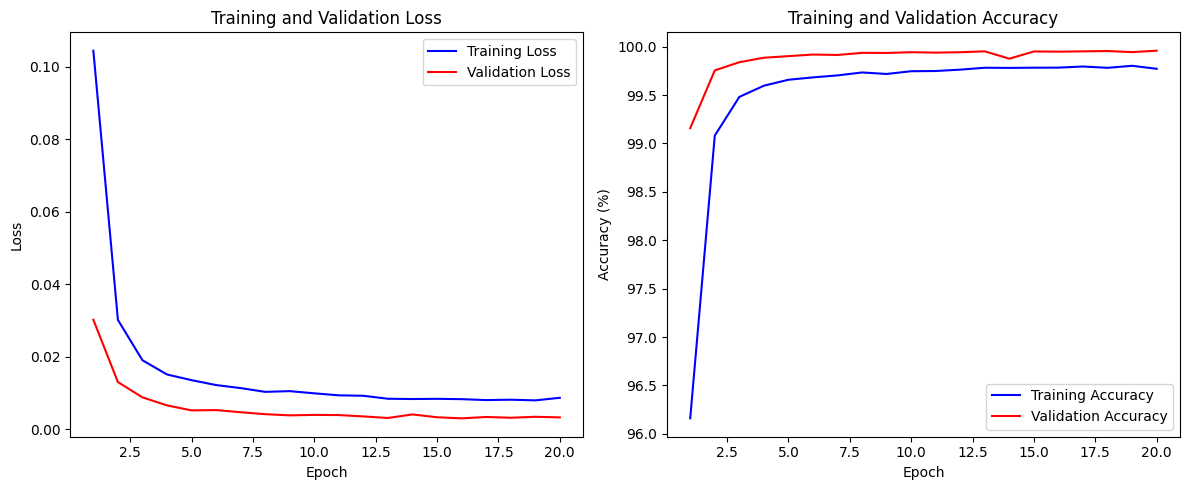

Accuratezza sul test set: 0.9990

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud      1.000     0.999     0.999     56864
       Fraud      0.659     0.827     0.733        98

    accuracy                          0.999     56962
   macro avg      0.829     0.913     0.866     56962
weighted avg      0.999     0.999     0.999     56962



In [ ]:
train_loader, val_loader, test_loader = prepare_data_loaders(
    X_train_over, y_train_over, X_val_over, y_val_over, X_test, y_test, batch_size=300
)

input_size = X_train_over.shape[1] 
model = FraudDetectionNN(input_size)

history = train_model(
    model, train_loader, val_loader,
    num_epochs=20, learning_rate=0.001, plot_results=True
)

predictions, true_labels, accuracy = evaluate_model(model, test_loader)

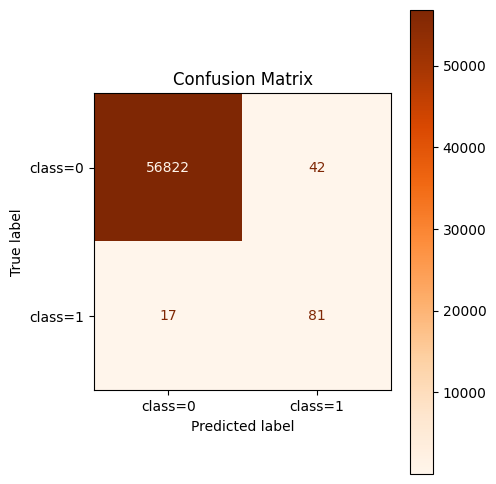

In [29]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["class=0", "class=1"], cmap='Oranges', ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
class FraudDetectionNN_Small(nn.Module):
    def __init__(self, input_size):
        super(FraudDetectionNN_Small, self).__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.52)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.batch_norm2 = nn.BatchNorm1d(8)
    
    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

Inizio training...
Epoca [1/25], Train Loss: 0.7303, Train Acc: 45.87%, Val Loss: 0.6869, Val Acc: 36.08%
Epoca [2/25], Train Loss: 0.7077, Train Acc: 49.05%, Val Loss: 0.6678, Val Acc: 39.24%
Epoca [3/25], Train Loss: 0.6787, Train Acc: 56.35%, Val Loss: 0.6380, Val Acc: 51.27%
Epoca [4/25], Train Loss: 0.6709, Train Acc: 55.08%, Val Loss: 0.6582, Val Acc: 63.92%
Epoca [5/25], Train Loss: 0.6632, Train Acc: 55.56%, Val Loss: 0.6281, Val Acc: 75.32%
Epoca [6/25], Train Loss: 0.6548, Train Acc: 58.10%, Val Loss: 0.6345, Val Acc: 76.58%
Epoca [7/25], Train Loss: 0.6619, Train Acc: 57.14%, Val Loss: 0.6365, Val Acc: 77.85%
Epoca [8/25], Train Loss: 0.6323, Train Acc: 63.65%, Val Loss: 0.6011, Val Acc: 87.97%
Epoca [9/25], Train Loss: 0.6427, Train Acc: 63.81%, Val Loss: 0.6034, Val Acc: 84.18%
Epoca [10/25], Train Loss: 0.6471, Train Acc: 63.33%, Val Loss: 0.6182, Val Acc: 75.95%
Epoca [11/25], Train Loss: 0.6438, Train Acc: 62.86%, Val Loss: 0.5746, Val Acc: 85.44%
Epoca [12/25], Train L

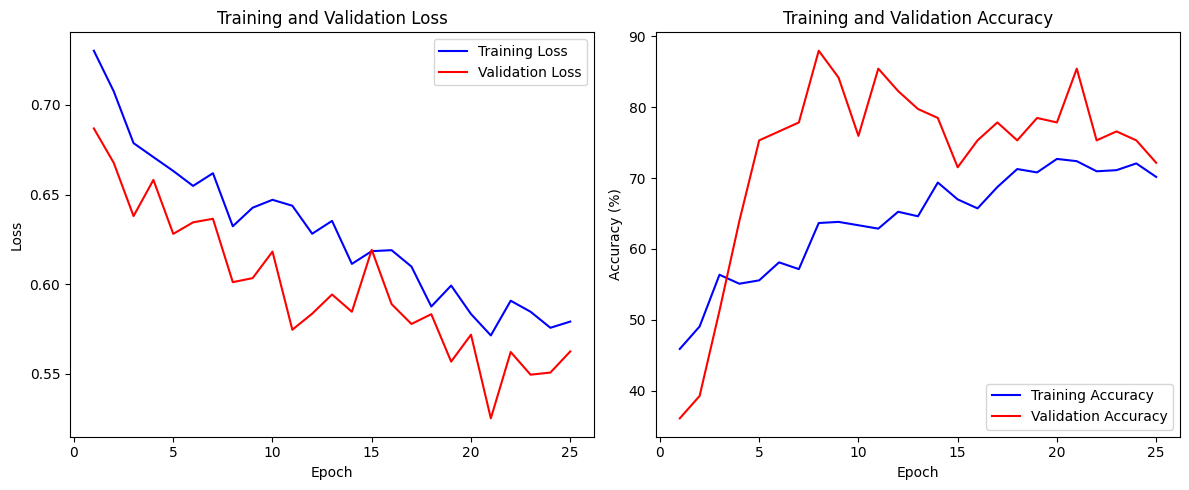

Accuratezza sul test set: 0.9969

Classification Report:
              precision    recall  f1-score   support

   Non-Fraud      0.999     0.998     0.998     56864
       Fraud      0.266     0.469     0.339        98

    accuracy                          0.997     56962
   macro avg      0.632     0.734     0.669     56962
weighted avg      0.998     0.997     0.997     56962



In [ ]:
train_loader, val_loader, test_loader = prepare_data_loaders(
    X_train_under, y_train_under, X_val_under, y_val_under, X_test, y_test, batch_size=5
)

input_size = X_train_under.shape[1]
model = FraudDetectionNN_Small(input_size)

history = train_model(
    model, train_loader, val_loader,
    num_epochs=25, learning_rate=0.0001, weight_decay=0.0001, plot_results=True
)

predictions, true_labels, accuracy = evaluate_model(model, test_loader)

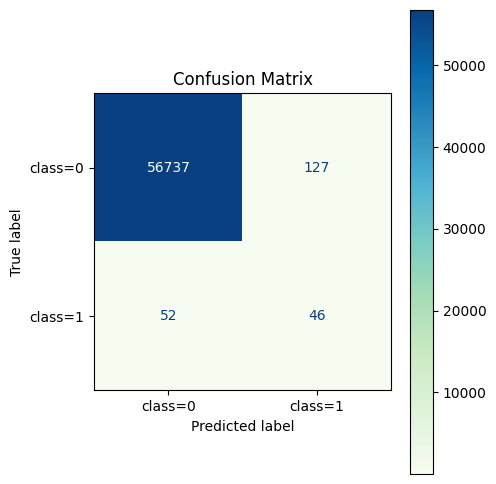

In [32]:
fig, ax = plt.subplots(figsize=(5, 5))
ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=["class=0", "class=1"], cmap='GnBu', ax=ax)
ax.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()